# Predict the class of bike riders. 

<center>
    <img src = images/nycbike.png width = 80%/>
</center>

In this dataset, we will explore the new york city bike rider's trips. The information about the rider's trip is located <a href="https://ride.citibikenyc.com/system-data">here</a>. For the capstone project, we will be taking information from May 2022 to November 2022. At the time of beginning this project, data for december 2022 is not available. The dataset contains information on 676k trip riders from the last 6 months. 

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>

For this capstone project, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.

# Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

## 1.1) Business Question

Given a dataset containing information bike riders trip attributes, predict the class of biker riders. 

## 1.2) Understanding of Business

Citibank nyc publishes the bike riders trip data every month. The data contains information which will help to answer the following questions 
###### 1) Where do Citi Bikers ride? 
###### 2) When do they ride? 
###### 3) How far do they go? 
###### 4) Which stations are most popular? 
###### 5) What days of the week are most rides taken on?

# Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In order to understand the data, some required libraries are imported to run few basic stats about the data. Navigating through the dataset using shape to determine the number of rows and columns and using the describe and info function to determine the mean,std and count along with the type of columns will help in next steps. 

## 2.1) Data Collection - Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta

import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from scipy import stats  as ss
from geopy.distance import geodesic
import holidays

from sklearn import preprocessing as pp
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report,plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, precision_score,recall_score,accuracy_score,f1_score,balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV



from sklearn.model_selection import StratifiedKFold

from imblearn import combine as c
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr, kendalltau
import scipy.stats as ss


from sklearn.dummy import DummyClassifier
import random

import warnings
warnings.filterwarnings("ignore")


## 2.2) Data Collection - Load Data

In [2]:
df_202211_raw = pd.read_csv('data/JC-202211-citibike-tripdata.csv')
df_202210_raw = pd.read_csv('data/JC-202210-citibike-tripdata.csv')
df_202209_raw = pd.read_csv('data/JC-202209-citibike-tripdata.csv')
df_202208_raw = pd.read_csv('data/JC-202208-citibike-tripdata.csv')
df_202207_raw = pd.read_csv('data/JC-202207-citbike-tripdata.csv')
df_202206_raw = pd.read_csv('data/JC-202206-citibike-tripdata.csv')
df_202205_raw = pd.read_csv('data/JC-202205-citibike-tripdata.csv')
df_202204_raw = pd.read_csv('data/JC-202204-citibike-tripdata.csv')
df_202203_raw = pd.read_csv('data/JC-202203-citibike-tripdata.csv')
df_202202_raw = pd.read_csv('data/JC-202202-citibike-tripdata.csv')
df_202201_raw = pd.read_csv('data/JC-202201-citibike-tripdata.csv')

df_raw = pd.concat( [
                     df_202201_raw,
                     df_202202_raw,
                     df_202203_raw,
                     df_202204_raw,
                     df_202205_raw, 
                     df_202206_raw,
                     df_202207_raw,
                     df_202208_raw,
                     df_202209_raw,
                     df_202210_raw,
                     df_202211_raw
                    ] )

## 2.3 Data Collection - Describe Data

In [3]:
df_raw.describe()

start_lat      start_lng        end_lat        end_lng
count  846900.000000  846900.000000  845013.000000  845013.000000
mean       40.731910     -74.040440      40.731854     -74.040193
std         0.012108       0.012217       0.012235       0.012182
min        40.706495     -74.088964      40.640000     -74.140000
25%        40.721124     -74.046305      40.721124     -74.045953
50%        40.733670     -74.037977      40.733670     -74.037683
75%        40.740973     -74.030970      40.740973     -74.030970
max        40.754992     -74.023587      40.872412     -73.888271

## 2.4 Data Collection - Data Types

In [4]:
df_raw.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

## 2.5) Data Collection - Data Dimensions

In [5]:
df_raw.shape

(846900, 13)

## 2.6) Data Collection - Check NA

In [6]:
df_raw.isna().sum()

ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
start_station_name      10
start_station_id        10
end_station_name      2996
end_station_id        2996
start_lat                0
start_lng                0
end_lat               1887
end_lng               1887
member_casual            0
dtype: int64

# Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

## 3.1 Numerical and Categorical Attributes

In [7]:
df_raw['started_at'] = pd.to_datetime( df_raw['started_at'] )
df_raw['ended_at'] = pd.to_datetime( df_raw['ended_at'] )

In [8]:
df_raw['start_station_id'] = df_raw['start_station_id'].apply( lambda x: str(x) )
df_raw['end_station_id'] = df_raw['end_station_id'].apply( lambda x: str(x) )

In [9]:
num_attributes = df_raw.select_dtypes(include=['int64', 'float64'] )
cat_attributes = df_raw.select_dtypes(exclude=['int64', 'float64','datetime64[ns]'] )
time_attributes = df_raw.select_dtypes( include=['datetime64[ns]'] )
num_attributes.sample()

start_lat  start_lng    end_lat    end_lng
62975  40.728745 -74.032108  40.718355 -74.038914

In [10]:
cat_attributes.sample()

ride_id rideable_type start_station_name start_station_id  \
101001  3CAE389021148D3C  classic_bike  Clinton St & 7 St            HB303   

             end_station_name end_station_id member_casual  
101001  11 St & Washington St          HB502        member

In [11]:
time_attributes.sample()

started_at            ended_at
59449 2022-10-27 21:00:09 2022-10-27 21:05:57

## 3.2 Clean Dataset by dropping rows and columns 

#### The null values in the dataframe are less than 5% of the total rows. It is safe to drop those rows with missing information. Also, the missing rows are based on specific columns 

In [12]:
#drop rows with missing start_station_name and start_station_id
df_raw.drop(index=df_raw[df_raw['start_station_name'].isna() & df_raw['start_station_id'].isna()].index, inplace=True )
#drop rows with missing end_station_name and end_station_id
df_raw.drop(index=df_raw[df_raw['end_station_name'].isna() & df_raw['end_station_id'].isna()].index, inplace=True )
#drop rows with missing end_lat and end_lag
df_raw.drop(index=df_raw[df_raw['end_lat'].isna() & df_raw['end_lng'].isna() ].index, inplace=True )

df_raw.drop(index=df_raw[df_raw['start_station_name'].isna()].index, inplace=True )
df_raw.drop(index=df_raw[df_raw['end_station_name'].isna()].index, inplace=True )

In [13]:
#Since we are going to predict the member class here, it is better to drop these columns. 
df_raw.drop( ['start_station_name', 'start_station_id', 'end_station_name', 'end_station_id'], axis=1, inplace=True )

In [14]:
df_raw.isna().sum()

ride_id          0
rideable_type    0
started_at       0
ended_at         0
start_lat        0
start_lng        0
end_lat          0
end_lng          0
member_casual    0
dtype: int64

### Adding new columns for weekdays, month, year and duration 

In [15]:
# year:
df_raw['year'] = df_raw['started_at'].dt.year

# month:
df_raw['month'] = df_raw['started_at'].dt.month

# day:
df_raw['day'] = df_raw['started_at'].dt.day

# day_of_week:
# 0 - Monday
# 1 - Tuesday
# 2 - Wednesday
# 3 - Thursday
# 4 - Friday
# 5 - Saturday
# 6 - Sunday
df_raw['day_of_week'] = df_raw['started_at'].dt.weekday

# distance
# used the "geopy" library to calculate the distance between start lat/lng and end lat/lng.
# The documentation of this librarie is in this link: https://nominatim.org/release-docs/develop/api/Output/
df_raw['distance'] = df_raw.apply( lambda x: geodesic( (x['start_lat'], x['start_lng']), (x['end_lat'], x['end_lng']) ).km, axis=1 )

# holiday:
# I will use the "holidays" library to identify whether the date represents a holiday. An idea for a next cycle in the project is to differentiate, according to some rule, the different dates of the holidays.
# The documentation of this library is in this link: https://pypi.org/project/holidays/
# Another rule that I will use is to consider the eve of the dates as a "holiday".
df_raw['holidays'] = df_raw['started_at'].apply( lambda x: 'Holiday' if x in holidays.US() else 'Holiday' if x + timedelta(days=1) in holidays.US() else 'Normal day' )

# hour_of_day:
df_raw['hour_of_day'] = df_raw['started_at'].dt.hour + df_raw['started_at'].dt.minute/60.0

df_raw['duration'] = df_raw.apply( lambda x: (x['ended_at'] - x['started_at']).total_seconds(), axis=1 )
# season:
# - Winter -> December (12), January (01) and February (02);
# - Spring -> March (03), April (04) and May (05);
# - Summer -> Jun (06), July (07) and August (08);
# - Autumn -> September (09), October (10) and November (11).
df_raw['season'] = df_raw['started_at'].apply( lambda x: 'Winter' if x.month == 12 or x.month == 1 or x.month == 2 else 'Spring' if  x.month == 3 or x.month == 4 or x.month == 5 else 'Summer' if  x.month == 6 or x.month == 7 or x.month == 8 else 'Autumn' if  x.month == 9 or x.month == 10 or x.month == 11 else '')



## 3.3) Check for Outliers

<AxesSubplot: ylabel='duration'>

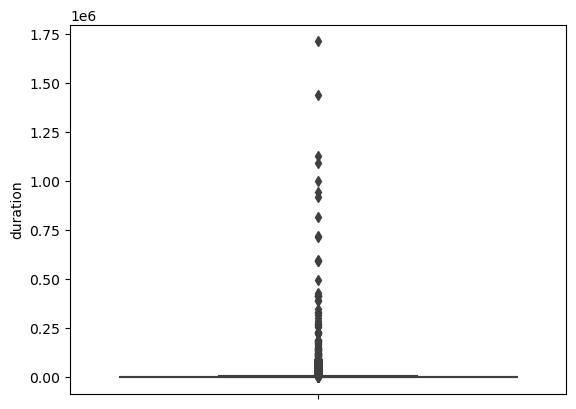

In [16]:
sns.boxplot(y=df_raw['duration'])

Removing outliers based on the above plot. We can clearly see that the we have number of fewer records that are above 5000 minutes. Filtering out those records along with additional filter to remove records over duration of 16.5 minutes.

(5201, 18)

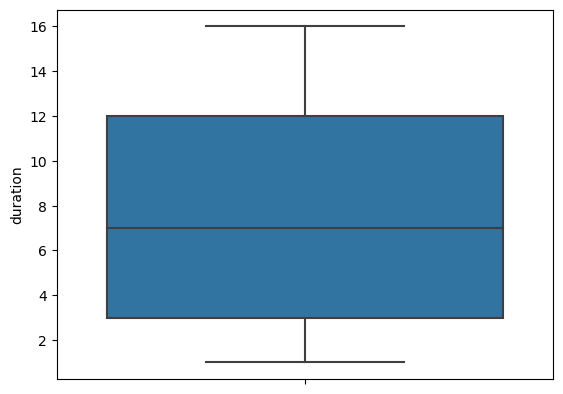

In [17]:
df_cleaned = df_raw[(df_raw['duration'] > 0) & (df_raw['duration'] < 16.5)]
sns.boxplot(y=df_cleaned['duration'])
df_cleaned.shape

In [18]:
df_casual_filter = df_cleaned[df_cleaned['member_casual'] == 'casual']
df_member_filter = df_cleaned[df_cleaned['member_casual'] == 'member']
print(df_casual_filter.shape)
print(df_member_filter.shape)

(1063, 18)
(4138, 18)


## 3.3) Check Unbalanced Data

In [19]:
df_balanced = df_cleaned[['ride_id', 'member_casual']].groupby( 'member_casual' ).count().sort_values( 'ride_id' ).reset_index()
df_balanced['perc%'] = 100*np.round( ( df_balanced['ride_id'] / np.sum( df_balanced['ride_id'] ) ), 4 )
df_balanced

member_casual  ride_id  perc%
0        casual     1063  20.44
1        member     4138  79.56

### Here we see that the data is pretty imbalanced. Rides with members are much more compared to casual. We have 3 ways to resolve this. 
1) Resampling <br />
2) Using F1 score and assigning more weigths to the minority <br />
3) SMOTETOmek <a href='https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html'>details</a><br />
We will be looking at the third option. 

In [20]:
# Encoder
ohe = pp.OneHotEncoder()

# Columns ( Categorical + Numerical )
cols_cat = df_cleaned.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] ).drop( ['ride_id', 'member_casual'], axis=1 ).columns.tolist()
cols_num = df_cleaned.select_dtypes( include=['int64', 'float64'] ).columns.tolist()

# One Hot Encoding Categorical
df_cleaned_dummy = pd.DataFrame( ohe.fit_transform( df_cleaned[cols_cat] ).toarray(), index=df_cleaned.index )

# joining back to original dataframe
df_cleaned_encoded = pd.concat( [df_cleaned[cols_num], df_cleaned_dummy], axis=1 )

SMOTETomek is a technique for addressing class imbalance in a dataset. It is an extension of the SMOTE (Synthetic Minority Oversampling Technique) method, which is a popular technique for oversampling a minority class in a dataset.The goal of this combination is to create a balanced dataset that is more representative of the true underlying distribution of the data.

In [21]:
# Oversampling ( SMOTE ) + Undersampling ( Tomek Links )
smt = c.SMOTETomek( sampling_strategy='auto', random_state=32 )
# apply
X_smt, y_smt = smt.fit_resample( df_cleaned_encoded, df_cleaned['member_casual'] )

# numerical data
df_smote_numerical = X_smt[ cols_num ]

# categorical data
df_smote_cats = X_smt.drop( cols_num, axis=1 )
df_smote_categorical = pd.DataFrame( ohe.inverse_transform( df_smote_cats ), columns=cols_cat, index=df_smote_cats.index )

# concat Numerical and Categorical dataset
df_smote_final = pd.concat( [df_smote_numerical, df_smote_categorical], axis=1 )
df_smote_final['member_casual'] = y_smt

### Checking to see if the data is balanced after oversampling and undersampling.

In [22]:
df_smote_final['member_casual'].value_counts(normalize=True )

member    0.5
casual    0.5
Name: member_casual, dtype: float64

## 3.4) Rename Columns 

In [23]:
df_smote_final.columns

Index(['start_lat', 'start_lng', 'end_lat', 'end_lng', 'year', 'month', 'day',
       'day_of_week', 'distance', 'hour_of_day', 'duration', 'rideable_type',
       'holidays', 'season', 'member_casual'],
      dtype='object')

### since the column names are pretty readable, we will keep the column names as the same. 

## 3.5) Descriptive Analysis

In [24]:
df_final_balanced = df_smote_final.copy()

### 3.5.1) Numerical and categorical variables 

In [25]:
num_attributes = df_final_balanced.select_dtypes(include=['int64', 'float64'] )
cat_attributes = df_final_balanced.select_dtypes(exclude=['int64', 'float64','datetime64[ns]'] )
time_attributes = df_final_balanced.select_dtypes( include=['datetime64[ns]'] )

#### Helper Functions

In [26]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

### 3.5.2) Numerical Variables

In [27]:
# Central Tendency
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

attributes          min          max      range         mean  \
0     start_lat    40.706575    40.754542   0.047966    40.732017   
1     start_lng   -74.088964   -74.023939   0.065025   -74.041919   
2       end_lat    40.706575    40.799484   0.092909    40.732034   
3       end_lng   -74.088964   -73.955613   0.133351   -74.041892   
4          year  2022.000000  2022.000000   0.000000  2022.000000   
5         month     1.000000    11.000000  10.000000     7.055116   
6           day     1.000000    31.000000  30.000000    15.506797   
7   day_of_week     0.000000     6.000000   6.000000     3.003955   
8      distance     0.000000    10.508788  10.508788     0.005189   
9   hour_of_day     0.000000    23.966667  23.966667    14.571353   
10     duration     1.000000    16.000000  15.000000     7.708204   

         median       std       skew     kurtosis  
0     40.732425  0.011450   0.077241    -1.028134  
1    -74.038914  0.013040  -1.046593     0.637759  
2     40.732427  0.011504   0.123482    -0.767513  
3    -74.038914  0.013119  -0.961412     1.031836  
4   2022.000000  0.000000   0.000000     0.000000  
5      7.000000  2.579229  -0.380587    -0.652171  
6     15.000000  8.765627   0.043053    -1.190439  
7      3.000000  1.924292  -0.054841    -1.211153  
8      0.000000  0.162285  57.712380  3487.574200  
9     15.666928  5.200343  -0.603993    -0.223662  
10     7.000000  4.608598   0.243117    -1.212009

#### 3.5.3) Categorical

In [28]:
cat_attributes.drop(['holidays','season'], axis=1 ).describe()

rideable_type member_casual
count           8092          8092
unique             3             2
top     classic_bike        member
freq            5667          4046

### 3.5.3) Predictors and Class Correlation

<AxesSubplot: >

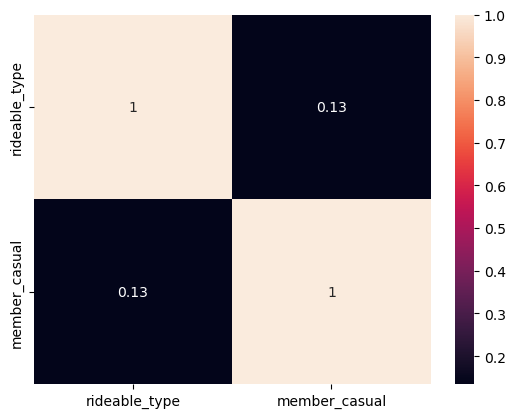

In [29]:
# list of categorical attributes
cat_attributes_list = cat_attributes.drop( ['holidays','season'], axis=1 ).columns.tolist()

corr_dict = {}
for i in range( len( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        #print( 'Ref: {} - Feat: {}'.format( cat_attributes_list[i], cat_attributes_list[j] ) )
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation between two categorical variables
        corr = cramer_v( cat_attributes[ ref ], cat_attributes[ feat ] )
        
        # append to a list
        corr_list.append( corr )
        
    # append the correlation list for each ref attributes
    corr_dict[ref] = corr_list

d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

## 3.5) Data Analysis 

### 3.5.1) Univariate Analysis ( Descriptive Statistics)

#### 3.5.1.1) Response Variable

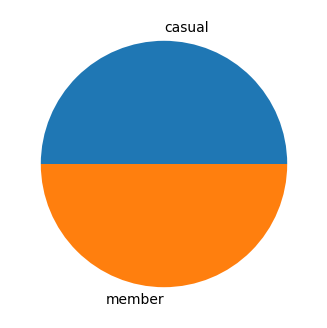

In [30]:
df_casual_filter = df_final_balanced[df_final_balanced['member_casual'] == 'casual']
df_member_filter = df_final_balanced[df_final_balanced['member_casual'] == 'member']
casual_count = df_casual_filter.shape[0]
member_count = df_member_filter.shape[0]
classes = ['casual','member']
counts = [casual_count, member_count]

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(4)

# Create the pie chart
plt.pie(counts, labels=classes)
# Show the plot
plt.show()

A series of plots to first explore the trips distribution over day-of-week and month.

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6')])

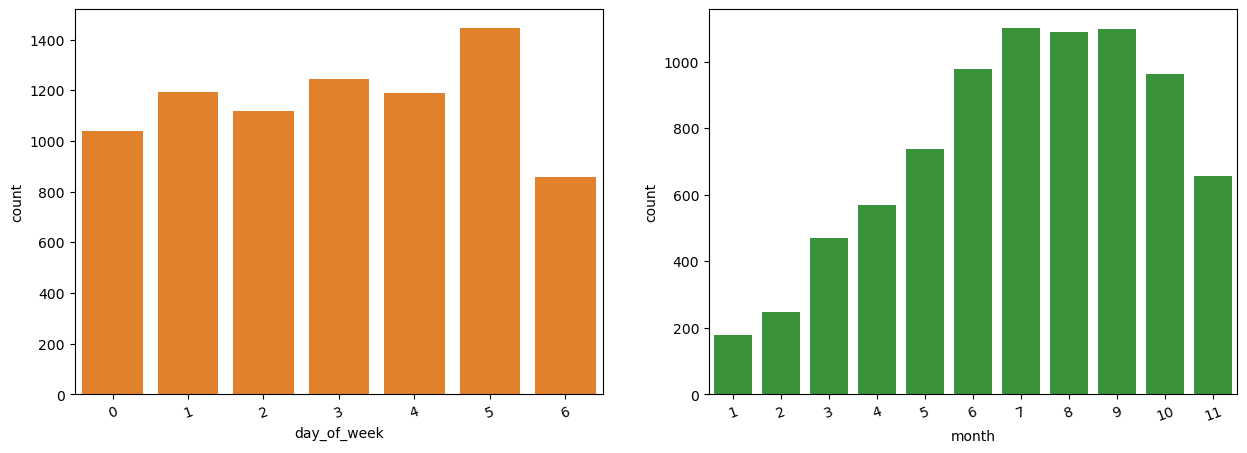

In [31]:
#Getting distribution using Seaborn bar plot 
plt.figure(figsize = [15,5])
base_color1=sns.color_palette()[1]
base_color2=sns.color_palette()[2]

# trip distribution over months
plt.subplot(1, 2, 2) # 1 row, 2 cols, subplot 2
g=sns.countplot(data = df_final_balanced, x = 'month', color=base_color2)
plt.xticks(rotation=20);

# trip distribution over weekday
plt.subplot(1, 2, 1) # 1 row, 2 cols, subplot 1
g=sns.countplot(data = df_final_balanced, x = 'day_of_week', color=base_color1)
plt.xticks(rotation=20)

Looking in combined with the trip distribution over day of week plot, the majority of rides happened on tuesday - friday and primary usage is probably for commuting. In the 11 months in 2022, August had the most ride trips compared to the others, but overall it was the most popular during summer time (June-October), probably due to the weather in the area.

### Trip distribution over bike type

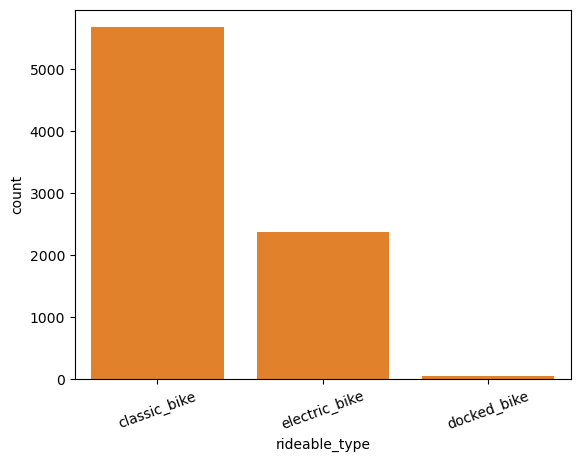

In [32]:
g=sns.countplot(data = df_final_balanced, x = 'rideable_type', color=base_color1)
plt.xticks(rotation=20);

In [33]:
from pandas_profiling   import ProfileReport
prof = ProfileReport(df_final_balanced)
correlations = prof.description_set["correlations"]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

### 3.5.2) Bivariate Analysis 

Ridable Type

In [34]:
aux01 = pd.crosstab( df_final_balanced['member_casual'], df_final_balanced['rideable_type'] ).apply( lambda x: 100*np.round( x / x.sum(), 2 ), axis=1 )
data = []
for x in aux01.columns:
   data.append(go.Bar(name=str(x), x=aux01.index, y=aux01[x]))

figure = go.Figure(data)
figure.update_layout(barmode = 'stack')
figure.show()

# Correlation: Cramer's V
r = cramer_v( df_final_balanced['member_casual'], df_final_balanced['rideable_type'] )
print( 'Correlation: {}'.format( r ) )

Correlation: 0.13445691528932743


### Holidays

In [35]:
aux01 = pd.crosstab( df_final_balanced['member_casual'], df_final_balanced['holidays'] ).apply( lambda x: 100*np.round( x / x.sum(), 2 ), axis=1 )
data = []
for x in aux01.columns:
   data.append(go.Bar(name=str(x), x=aux01.index, y=aux01[x]))

figure = go.Figure(data)
figure.update_layout()
figure.show()


# Correlation: Cramer's V
r = cramer_v( df_cleaned['member_casual'], df_cleaned['holidays'] )
print( 'Correlation: {}'.format( r ) )

Correlation: 0.025533511355288183


### Season

In [36]:
aux01 = pd.crosstab( df_cleaned['member_casual'], df_cleaned['season'] ).apply( lambda x: 100*np.round( x / x.sum(), 2 ), axis=1 )
data = []
for x in aux01.columns:
   data.append(go.Bar(name=str(x), x=aux01.index, y=aux01[x]))

figure = go.Figure(data)
figure.update_layout()
figure.show()

# Correlation: Cramer's V
r = cramer_v( df_final_balanced['member_casual'], df_final_balanced['season'] )
print( 'Correlation: {}'.format( r ) )

Correlation: 0.1434113206988621


### 3.5.3 Multivariate Analysis

A pairplot in Python's seaborn library is a multivariate visualization technique that allows you to plot all pairs of variables in a dataset against each other. It creates a matrix of scatterplots, where each scatterplot represents the relationship between a pair of variables.

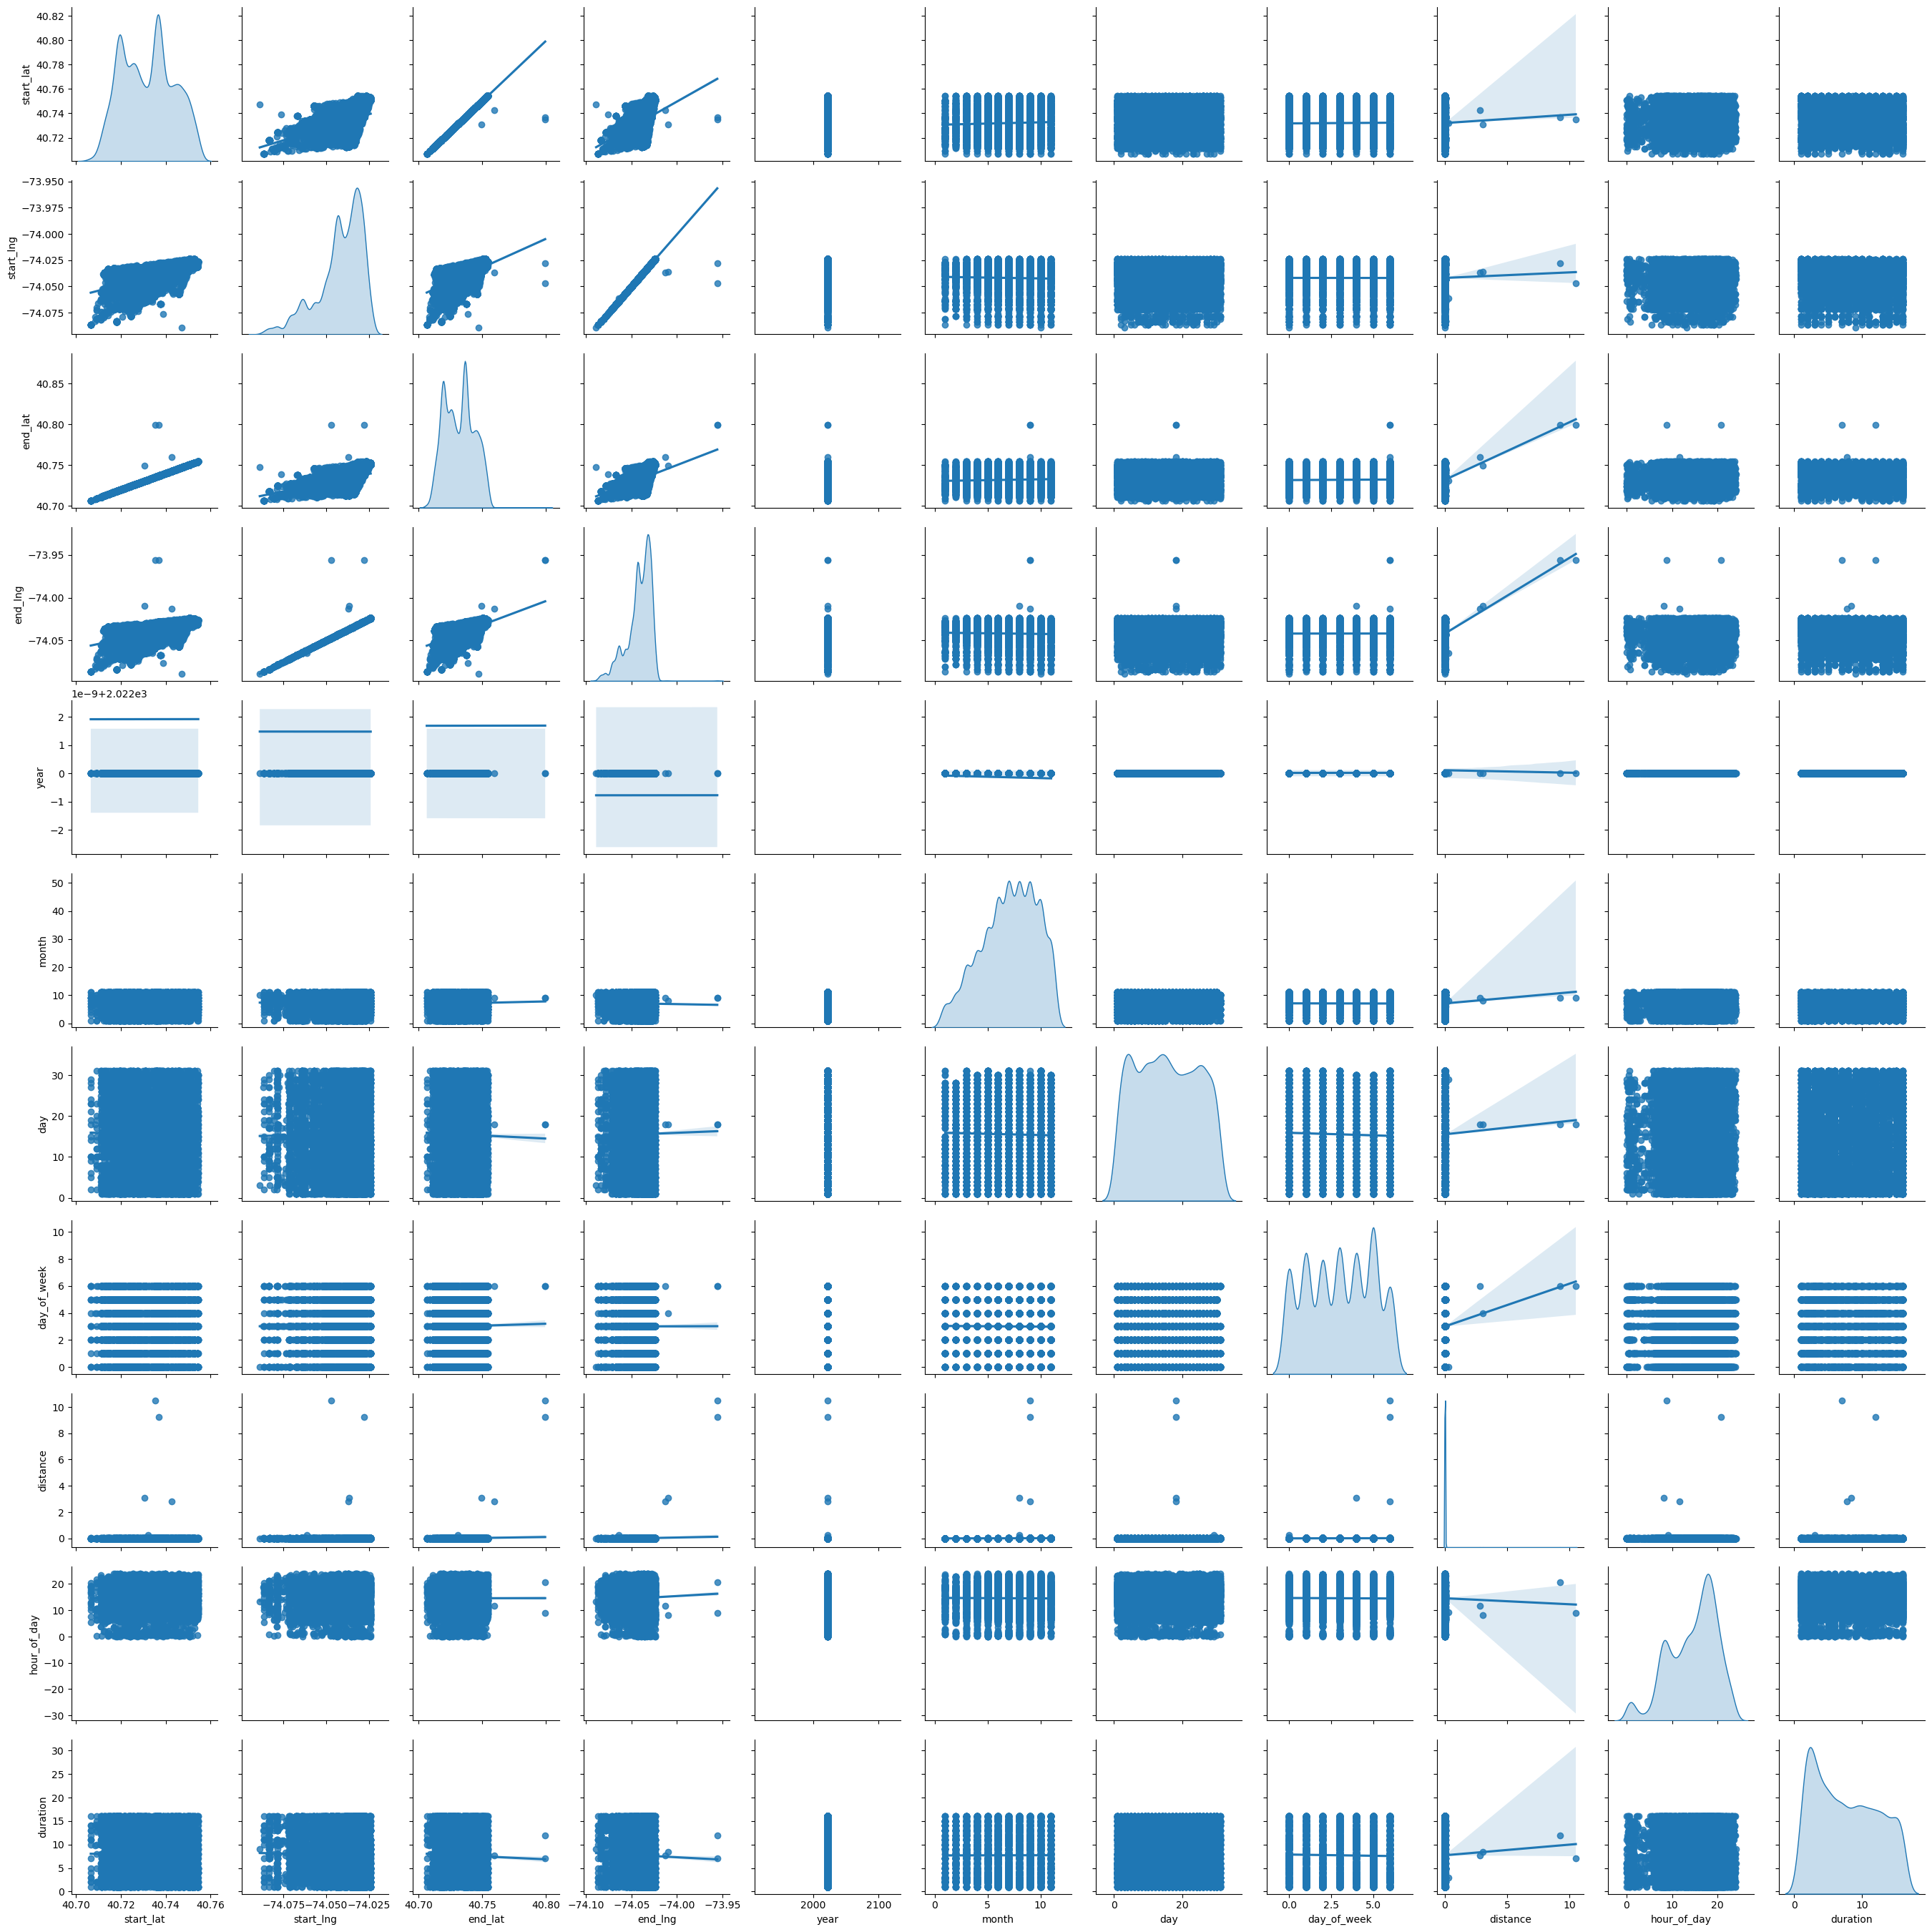

In [37]:
#Lets first visualize the variables involved
sns.pairplot(df_final_balanced, kind="reg", diag_kind="kde")

In [38]:
# list of categorical attributes
cat_attributes = df_final_balanced.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}
for i in range( len( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        #print( 'Ref: {} - Feat: {}'.format( cat_attributes_list[i], cat_attributes_list[j] ) )
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation between two categorical variables
        corr = cramer_v( cat_attributes[ ref ], cat_attributes[ feat ] )
        
        # append to a list
        corr_list.append( corr )
        
    # append the correlation list for each ref attributes
    corr_dict[ref] = corr_list

d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns )

# Add text labels for each cell in the grid
annotations = []
for i in range(len(d)):
    for j in range(len(d[i])):
        annotations.append(go.layout.Annotation(
            text=str(d[i][j]),
            x=j,
            y=i,
            xref="x",
            yref="y",
            showarrow=False
        ))


fig, axs = plt.subplots(2, 2, figsize=(400, 150))

spearman_corr = d.corr(method='spearman')
# Compute the Cramer correlations
cramer_corr = d
# Compute the Kendall correlations
kendall_corr = d.corr(method='kendall')
# Compute the Pearson correlations
pearson_corr = d.corr(method='pearson')


#ax = sns.heatmap(spearman_corr, ax=axs[0,0], cmap='coolwarm')
#ax.set(xlabel="", ylabel="")
#ax.xaxis.tick_top()

#sns.heatmap(cramer_corr, annot=True, ax=axs[0,1], cmap='coolwarm')
#sns.heatmap(kendall_corr, annot=True, ax=axs[1,0], cmap='coolwarm')
#sns.heatmap(pearson_corr, annot=True, ax=axs[1,1], cmap='coolwarm')
# Create the imshow plot
#fig = go.Figure(data=go.Heatmap(z=spearman_corr))

#print(data)





KeyError: 0

In [39]:
import plotly.graph_objects as go

# Create some data to plot
data = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]

# Create the imshow plot
fig = go.Figure(data=go.Heatmap(z=data))

# Add text labels for each cell in the grid
annotations = []
for i in range(len(data)):
    for j in range(len(data[i])):
        annotations.append(go.layout.Annotation(
            text=str(data[i][j]),
            x=j,
            y=i,
            xref="x",
            yref="y",
            showarrow=False
        ))

# Update the layout to include the annotations
fig.update_layout(annotations=annotations)

# Show the plot
fig.show()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [40]:
df_formatted = df_final_balanced.copy()

In [41]:
df_formatted.drop( 'year', axis=1, inplace=True )

## 4.1 Rescaling

### Since we took out the outliers already, we will not be making any changes to the duration column. 

In [42]:
fig = px.box(df_formatted, y="duration", points='all')
fig.show()

In [43]:
fig = px.box(df_formatted, y="distance", points='all')
fig.show()

In [44]:
ss = StandardScaler()
# durantion
df_formatted['duration'] = ss.fit_transform( df_formatted[['duration']].values )

# distance
df_formatted['distance'] = ss.fit_transform( df_formatted[['distance']].values )

## 4.2 Encoding

In [45]:
# rideable_type
df_formatted = pd.get_dummies( df_formatted, prefix=['rideable_type'], columns=['rideable_type'] )

# holidays
df_formatted = pd.get_dummies( df_formatted, prefix=['holidays'], columns=['holidays'] )

## 4.3 Transformation

Since I am trying to predict the demand for a product based on past sales data, it might be helpful to include features that capture the day of the week and the week of the month.We have couple of ways to do it. 

1) One way to do this is to create a new feature for each day of the week, with a value of 1 for the corresponding day and 0 for all other days. This approach treats the days of the week as discrete categories, which may not capture the full range of variation in the data.

2) Alternatively, we could use sine and cosine functions to represent the week of the day in a continuous manner. To do this, we would create two new features: one for the sine transformation and one for the cosine transformation. These features would take on values that depend on the day of the week and the week of the month.

Incorporating these features into your machine learning model could help to capture patterns in the data that are related to the day of the week and the week of the month. 


In [46]:
def transform_variable(day, total):
  # Convert the day of the week to an angle in radians, with Sunday as the starting point
  angle = 2 * np.pi * day / total
  
  # Compute the sine and cosine transformations of the angle
  sine = np.sin(angle)
  cosine = np.cos(angle)
  
  return sine, cosine

In [47]:
# month
sine1,cosine1 = transform_variable(df_formatted['month'], 4)
df_formatted['month_sin'] = sine1
df_formatted['month_cos'] = cosine1

sine2,cosine2 = transform_variable(df_formatted['day'], 30)
df_formatted['day_sin'] = sine2
df_formatted['day_cos'] = cosine2

sine3,cosine3 = transform_variable(df_formatted['day_of_week'], 7)
df_formatted['day_of_week_sin'] = sine3
df_formatted['day_of_week_cos'] = cosine3

sine4,cosine4 = transform_variable(df_formatted['hour_of_day'], 24)
df_formatted['hour_of_the_day_sin'] = sine4
df_formatted['hour_of_the_day_cos'] = cosine4

season_dict = { 'Winter': 0, 'Spring': 1, 'Summer':2, 'Autumn':3 }
df_formatted['season'] = df_formatted['season'].map(season_dict)

sine5,cosine5 = transform_variable(df_formatted['season'],4)
df_formatted['season_sin'] = sine5
df_formatted['season_cos'] = cosine5

cols_drop = ['month', 'day', 'day_of_week', 'hour_of_day', 'season']
df_formatted = df_formatted.drop( cols_drop, axis=1 )

In [48]:
df_formatted.head()

start_lat  start_lng    end_lat    end_lng  distance  duration  \
0  40.750604 -74.024020  40.750604 -74.024020 -0.031974 -1.455584   
1  40.715178 -74.037683  40.715178 -74.037683 -0.031974 -0.804627   
2  40.715178 -74.037683  40.715178 -74.037683 -0.031974  0.931258   
3  40.715178 -74.037683  40.715178 -74.037683 -0.031974  0.063316   
4  40.715178 -74.037683  40.715178 -74.037683 -0.031974 -0.587642   

  member_casual  rideable_type_classic_bike  rideable_type_docked_bike  \
0        member                           1                          0   
1        member                           1                          0   
2        member                           1                          0   
3        member                           0                          0   
4        member                           1                          0   

   rideable_type_electric_bike  ...  month_sin     month_cos   day_sin  \
0                            0  ...        1.0  6.123234e-17  0.207912   
1                            0  ...        1.0  6.123234e-17 -0.866025   
2                            0  ...        1.0  6.123234e-17 -0.866025   
3                            1  ...        1.0  6.123234e-17 -0.406737   
4                            0  ...        1.0  6.123234e-17 -0.951057   

    day_cos  day_of_week_sin  day_of_week_cos  hour_of_the_day_sin  \
0  0.978148        -0.974928        -0.222521             0.652760   
1  0.500000         0.781831         0.623490            -0.938191   
2  0.500000         0.781831         0.623490            -0.944089   
3 -0.913545         0.000000         1.000000            -0.224951   
4  0.309017         0.000000         1.000000            -0.979925   

   hour_of_the_day_cos  season_sin  season_cos  
0             0.757565         0.0         1.0  
1            -0.346117         0.0         1.0  
2             0.329691         0.0         1.0  
3            -0.974370         0.0         1.0  
4            -0.199368         0.0         1.0  

[5 rows x 22 columns]

## 4.4) Feature Selection

In [49]:
X = df_formatted.drop( ['member_casual'], axis=1)
y = df_formatted['member_casual'] 

# split traininset between train and test
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=43, stratify=y )

**We will use Random Forest Classifier to select the features**

In [50]:
model = RandomForestClassifier()
#Create the RFE object and specify the number of features to select
rfe = RFE(model, n_features_to_select=10)
# Fit the RFE object to the data
rfe.fit(X, y)
# Print the selected feature\s
selected_features = X.columns[rfe.support_]
selected_features

Index(['start_lat', 'start_lng', 'end_lat', 'end_lng', 'duration', 'day_sin',
       'day_cos', 'day_of_week_sin', 'hour_of_the_day_sin',
       'hour_of_the_day_cos'],
      dtype='object')

In [51]:
#create an array of selected features
rf_features = np.array(selected_features)

In [52]:
#create an array of unselected features
rf_features_not_selected = list(np.setdiff1d( X_train.columns, rf_features ) )

## 4.5) Machine Learning Modeling

In [53]:
x_train = X_train[rf_features]
x_test = X_test[rf_features]

r_seed = 42

There are several types of machine learning models that can be used for classification tasks. We will be seeing the following ones below. 

**Logistic Regression** : This is a linear model that is used for binary classification tasks. It is based on the idea of finding the probability of an event occurring, given a set of independent variables.

**Decision Trees**: These are tree-based models that can be used for classification tasks. A decision tree makes decisions based on the feature values of an input.

**Support Vector Machines (SVMs)**: These are linear models that find the hyperplane in a high-dimensional space that maximally separates different classes. They are effective in high-dimensional spaces and are often used in text classification problems.

**K-Nearest Neighbors (KNN)**: This is a simple, non-parametric method that can be used for classification tasks. It works by finding the K data points in the training set that are closest to the sample, and using their labels to predict the label of the sample.

**Random Forests**: These are ensemble models that are composed of a large number of decision trees. They work by training multiple decision trees on random subsets of the data, and then averaging the predictions of all the trees to make a final prediction.

Before we begin lets define some helper functions that we will use to output the scores. We will be using this to determine the best model. 

In [110]:
def GenerateOutput(model_name,x_test,y_test, y_pred,model):
    # Accuracy - Precision - Recall - F1 Score - Kappa Metrics - Confusion Matrix
    print(classification_report( y_test, y_pred, digits=2) )
    #confusion matrix display
    lr_matrix = ConfusionMatrixDisplay.from_predictions(y_test,y_pred, display_labels=['casual', 'member'])

    # =========== Balanced Dataframe Metrics =============
    # Accuracy
    lr_acc = accuracy_score( y_test, y_pred)
    #print( 'Accuracy: {}'.format(lr_acc))


    # =========== Unbalanced Dataframe Metrics =============
    # Weighted F1-Score
    f1score = f1_score( y_test, y_pred, average='weighted' )
    #print( 'Weighted F1-Score: {}'.format( f1score ) )

    # Balanced Accuracy Score
    balanced_acc = balanced_accuracy_score( y_test, y_pred )
    #print( 'Balanced Accuracy Score: {}'.format( balanced_acc))
    
    if(model_name == "Baseline model"):
        model = DummyClassifier(random_state=r_seed)
    
    model.fit(x_train, y_train)
    
    y_pred_proba = model.predict_proba(x_test)[:, 1]
    # Calculate the AUC-ROC score
    auc = roc_auc_score(y_test, y_pred_proba)
    #print("AUC-ROC:", auc)
    
    df_score = CalculateScores(model_name,lr_acc,f1score,balanced_acc,auc)
    return df_score

def CalculateScores(model_name, accuracy, f1_score, balanced_accuracy, roc_auc):
    return pd.DataFrame( { 'Model Name': model_name,
                           'accuracy': accuracy,
                           'f1_score': f1_score,
                           'balanced_accuracy': balanced_accuracy,
                           'roc_auc score': roc_auc }, index=[0] ) 

def CrossVal_model(modelName, x_train, y_train):
    #As discussed above, we will be using stratifiedKfold to deal with imbalanced data. 
    fold = 5
    kfold = StratifiedKFold(n_splits=fold, shuffle=True,random_state=r_seed)

    accuracy_list = []
    balanced_acc_list = []
    weighted_f1_score_list = []
    auc_score_list = []
    iter = 1
    for train_index, test_index in kfold.split(x_train, y_train):
        X_train_f, X_test_f = x_train.iloc[train_index], x_train.iloc[test_index]
        y_train_f, y_test_f = y_train.iloc[train_index], y_train.iloc[test_index]

        if(modelName == "Logistic Regression"):
            #define a Logistic Regression model
            model = LogisticRegression(random_state=r_seed)
        if(modelName == "SVM"):
            model = svm.SVC(random_state=r_seed, probability=True)
        if(modelName == "DecisionTree"):
            model = DecisionTreeClassifier(random_state=r_seed)
        if(modelName == "RandomForestClassifier"):
            model = RandomForestClassifier(random_state=r_seed)
       
        
        #fit the model 
        model.fit(X_train_f, y_train_f)
        #prediction 
        y_f_pred = model.predict(X_test_f)
        #Accuracy 
        acc = accuracy_score(y_test_f, y_f_pred)
        accuracy_list.append(acc)
        # Balanced Accuracy
        balanced_acc = balanced_accuracy_score( y_test_f, y_f_pred )
        balanced_acc_list.append( balanced_acc )
        # Weighted F1-Score
        weighted_f1_score = f1_score( y_test_f, y_f_pred, average='weighted')
        weighted_f1_score_list.append( weighted_f1_score )
        
        #auc score 
        y_pred_proba = model.predict_proba(X_test_f)[:, 1]
        # Calculate the AUC-ROC score
        auc = roc_auc_score(y_test_f, y_pred_proba) 
        auc_score_list.append(auc)
        iter += 1

    print( 'Avg Balanced Accuracy: {}'.format( np.mean( balanced_acc_list ) ) )
    print( 'Avg Weighted F1-Score: {}'.format( np.mean( weighted_f1_score_list ) ) )
    print( 'Avg AUC-ROC Score: {}'.format( np.mean( auc_score_list ) ) )
    
    modelName = modelName + " - Cross Validation"
    
    return CalculateScores(modelName,np.mean(accuracy_list), 
                            np.mean( balanced_acc_list ),np.mean( weighted_f1_score_list),np.mean( auc_score_list))
    


### 4.5.1) Baseline model

**A baseline model in machine learning is a simple model that serves as a reference point or starting point for comparison with more complex models. The goal of a baseline model is to establish a minimum level of performance that any more complex model should aim to surpass.Since we already know that the data is unbalanced, we will use the same ratio to determine the model score**

In [111]:
target_list = y_test.drop_duplicates().sort_values().tolist()
target_weights = df_raw['member_casual'].value_counts( normalize=True ).sort_index().tolist()
# prediction
y_pred= random.choices(target_list, k=x_test.shape[0],
                              weights=target_weights )

In [112]:
x_test

start_lat  start_lng    end_lat    end_lng  duration   day_sin  \
3570  40.719586 -74.043117  40.719586 -74.043117 -0.153670  0.743145   
7224  40.733373 -74.037508  40.733373 -74.037508 -0.240400 -0.866025   
3081  40.754530 -74.026580  40.754530 -74.026580  1.148244 -0.866025   
1175  40.754530 -74.026580  40.754530 -74.026580  0.714273  0.207912   
2139  40.745910 -74.057271  40.745910 -74.057271  1.365230  0.406737   
...         ...        ...        ...        ...       ...       ...   
6947  40.725669 -74.050442  40.725669 -74.050442  0.844891  0.743145   
355   40.724176 -74.050656  40.724176 -74.050656 -1.238599  0.866025   
3697  40.749985 -74.027150  40.749985 -74.027150 -1.021613  0.587785   
3433  40.715178 -74.037683  40.715178 -74.037683 -0.587642 -0.587785   
7868  40.739144 -74.037829  40.739144 -74.037829  1.647181  0.866025   

       day_cos  day_of_week_sin  hour_of_the_day_sin  hour_of_the_day_cos  
3570 -0.669131        -0.781831             0.139173             0.990268  
7224  0.500000         0.433884            -0.721794            -0.692108  
3081 -0.500000        -0.974928            -0.382683            -0.923880  
1175 -0.978148        -0.974928            -0.803857            -0.594823  
2139 -0.913545         0.974928            -0.117537             0.993068  
...        ...              ...                  ...                  ...  
6947  0.669131        -0.974928            -0.049627            -0.998768  
355  -0.500000         0.433884            -0.241922            -0.970296  
3697  0.809017        -0.974928            -0.984808             0.173648  
3433  0.809017         0.781831            -0.740218             0.672367  
7868  0.500000        -0.433884            -0.934169             0.356831  

[2428 rows x 10 columns]

### Performance

              precision    recall  f1-score   support

      casual       0.50      0.36      0.42      1214
      member       0.50      0.64      0.56      1214

    accuracy                           0.50      2428
   macro avg       0.50      0.50      0.49      2428
weighted avg       0.50      0.50      0.49      2428



Model Name  accuracy  f1_score  balanced_accuracy  roc_auc score
0  Baseline model  0.500824  0.490839           0.500824            0.5

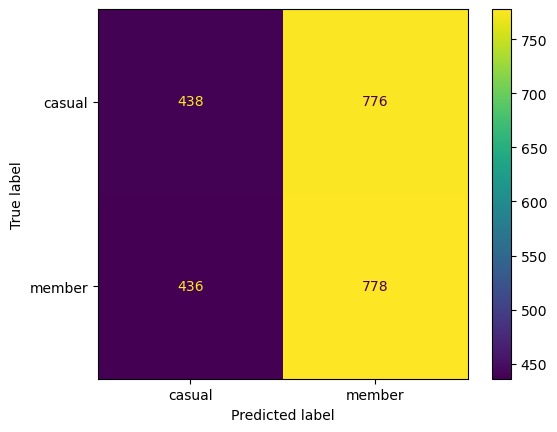

In [113]:
df_score_base = GenerateOutput("Baseline model",x_test,y_test, y_pred, DummyClassifier())
df_score_base

**Helper Function**
We will use this function for generating output information that will be used across different machine learning models. 

### 4.5.2) Logistic Regression

In [114]:
#model definition
mlm_lr = LogisticRegression(random_state=r_seed)
#fit the model
mlm_lr.fit(x_train, y_train)

LogisticRegression(random_state=42)

### 4.5.2.1) Logistic Regression Performance 

In [115]:
y_pred = mlm_lr.predict(x_test)

              precision    recall  f1-score   support

      casual       0.59      0.58      0.58      1214
      member       0.58      0.59      0.59      1214

    accuracy                           0.59      2428
   macro avg       0.59      0.59      0.59      2428
weighted avg       0.59      0.59      0.59      2428



Model Name  accuracy  f1_score  balanced_accuracy  roc_auc score
0  Logistic Regression  0.585255  0.585224           0.585255       0.613086

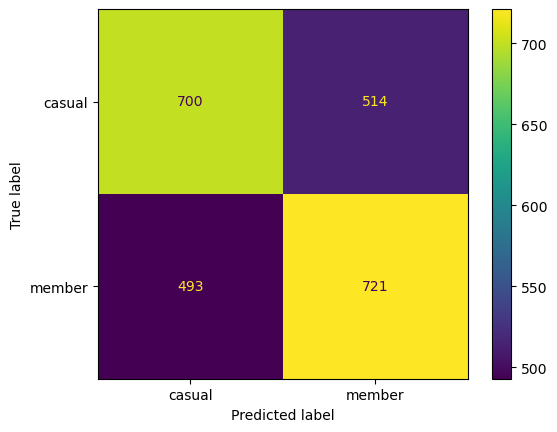

In [116]:
df_score = GenerateOutput("Logistic Regression",x_test,y_test, y_pred,mlm_lr)
df_score

### 4.5.3) Logistic Regression - Cross Validation

StratifiedKFold is a type of cross-validation technique used to evaluate the performance of machine learning models. It is a variant of KFold, which divides the data into a specified number of folds (or "splits") and iteratively trains and evaluates the model on each fold. <br />
The key difference between StratifiedKFold and KFold is that StratifiedKFold ensures that the proportion of samples belonging to each class is approximately the same across all the folds. This is particularly useful when the data is imbalanced, meaning that one class is significantly more prevalent than the others.

In [117]:
df_score2 = CrossVal_model("Logistic Regression", x_train, y_train)
df_score2

Avg Balanced Accuracy: 0.5768012164949738
Avg Weighted F1-Score: 0.5765690806665329
Avg AUC-ROC Score: 0.5990536465131395


Model Name  accuracy  f1_score  \
0  Logistic Regression - Cross Validation  0.576797  0.576801   

   balanced_accuracy  roc_auc score  
0           0.576569       0.599054

### 4.5.4) Model: K-Nearest Neighbour

K-Nearest Neighbors (KNN) is a simple and popular machine learning algorithm that can be used for both classification and regression.<br />

In the case of KNN classification, the algorithm works by finding the K nearest neighbors of a given data point and using their class labels to predict the class label of the data point. For example, if the K nearest neighbors of a data point are all labeled as "positive," the data point is predicted to be positive as well.<br />

On the other hand, KNN regression works by finding the K nearest neighbors of a given data point and using their values to predict the value of the data point. For example, if the K nearest neighbors of a data point have values of 1, 2, and 3, the predicted value for the data point might be 2 (the average of the values of the nearest neighbors).<br />



In [118]:
# model definition
model_knn = KNeighborsClassifier(n_neighbors=2)
# train model
model_knn.fit(x_train,y_train )

KNeighborsClassifier(n_neighbors=2)

#### 4.5.4.1) KNN Performance

              precision    recall  f1-score   support

      casual       0.65      0.93      0.76      1214
      member       0.88      0.49      0.63      1214

    accuracy                           0.71      2428
   macro avg       0.76      0.71      0.70      2428
weighted avg       0.76      0.71      0.70      2428



Model Name  accuracy  f1_score  balanced_accuracy  roc_auc score
0        KNN  0.712932  0.698168           0.712932       0.775747

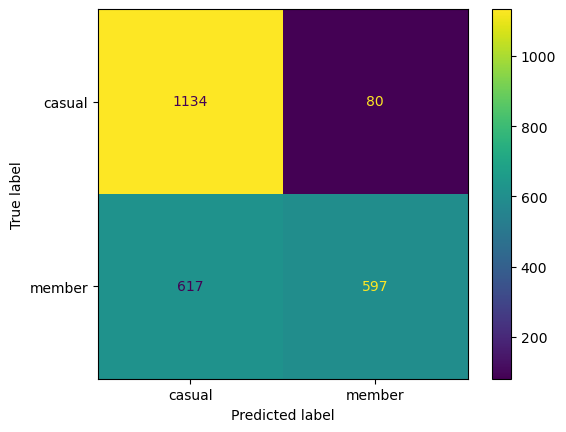

In [119]:
#prediction
y_pred = model_knn.predict(x_test)
df_score3 = GenerateOutput('KNN',x_test,y_test, y_pred, model_knn)
df_score3

#### 4.5.4.2) N-neighbors fine tuning

In [121]:
balanced_acc_list = []
for i in range( 1, 15 ):
    # model definition
    model_knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1 )
    # train model
    model_knn.fit( x_train, y_train )
    # prediction
    y_pred = model_knn.predict( x_test )
    # Balanced Accuracy Score
    balanced_acc_list.append( balanced_accuracy_score( y_test, y_pred))

Text(0, 0.5, 'Balanced Accuracy')

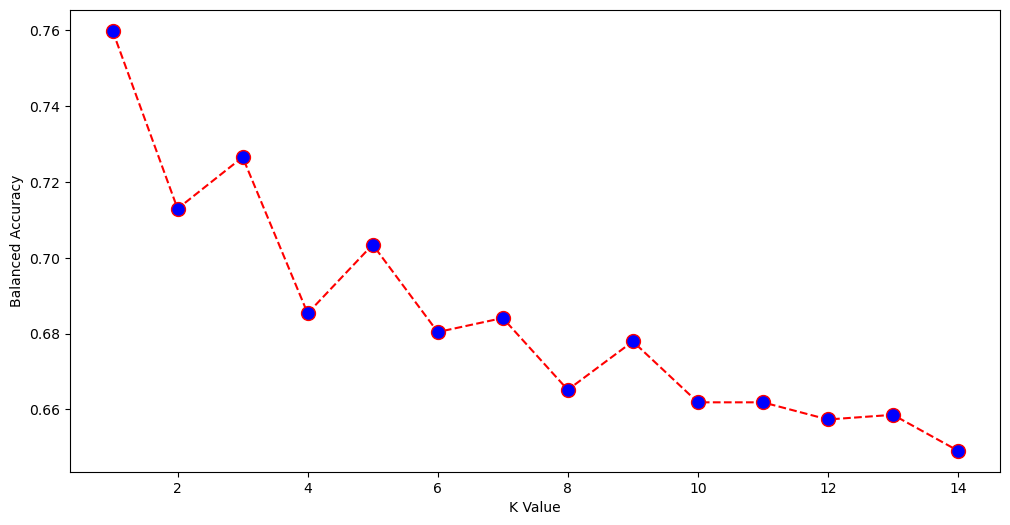

In [122]:
plt.figure( figsize=(12, 6) )
plt.plot( range( 1, 15 ), balanced_acc_list, color='red', linestyle='dashed', marker='o',
                                             markerfacecolor='blue', markersize=10 )
plt.xlabel('K Value' )
plt.ylabel('Balanced Accuracy')

From the above, it is clear that n_neighbors with value 1 provides the highest accuracy. 

              precision    recall  f1-score   support

      casual       0.72      0.84      0.78      1214
      member       0.81      0.68      0.74      1214

    accuracy                           0.76      2428
   macro avg       0.77      0.76      0.76      2428
weighted avg       0.77      0.76      0.76      2428



Model Name  accuracy  f1_score  balanced_accuracy  roc_auc score
0        KNN  0.759885  0.758293           0.759885       0.759885

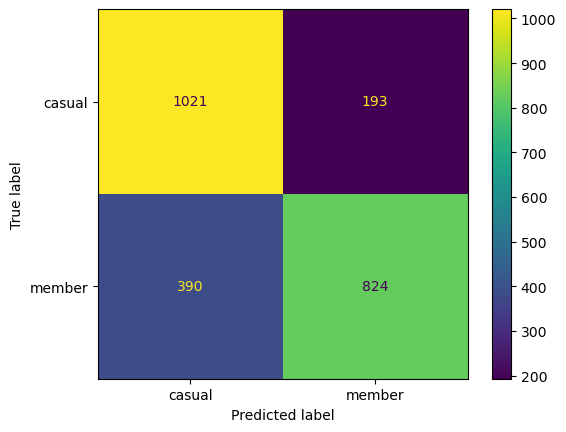

In [124]:
# model definition
model_knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1 )
# train model
model_knn.fit( x_train, y_train )
# prediction
y_pred = model_knn.predict( x_test )
#score calculation
df_score4 = GenerateOutput('KNN',x_test,y_test, y_pred, model_knn)
df_score4

## 4.5.5) Support Vector Machine(SVMs)

The main idea behind SVMs is to find the line (or hyperplane) that maximally separates the data points of different classes. This line is called the "maximum margin hyperplane." The points that lie closest to this line are called "support vectors." Once the support vectors are found, the algorithm uses them to construct the maximum margin hyperplane.<br />
However, SVMs can be sensitive to the choice of hyperparameters and can be computationally expensive to train, especially for large datasets. They also do not work well with noisy or highly imbalanced data, and they may not be suitable for tasks that require probability estimates.

In [133]:
# model definition
model_svm = svm.SVC(random_state=r_seed,probability=True)
# model training
model_svm.fit( x_train, y_train )

SVC(probability=True, random_state=42)

### 4.5.5.1) Performance

              precision    recall  f1-score   support

      casual       0.58      0.64      0.61      1214
      member       0.60      0.53      0.56      1214

    accuracy                           0.59      2428
   macro avg       0.59      0.59      0.59      2428
weighted avg       0.59      0.59      0.59      2428



Model Name  accuracy  f1_score  balanced_accuracy  roc_auc score
0        SVM  0.586491  0.585189           0.586491            0.5

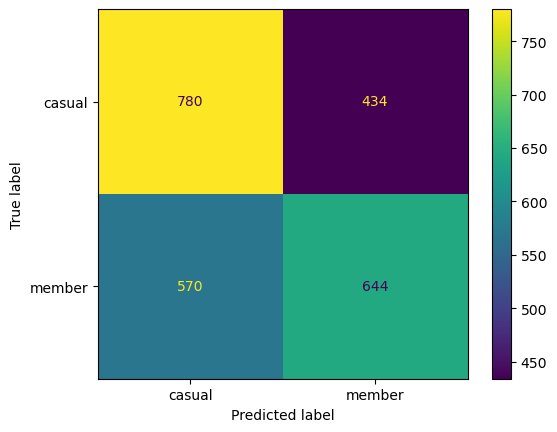

In [134]:
#prediction
y_pred = model_svm.predict(x_test)
df_score5 = GenerateOutput('SVM',x_test,y_test, y_pred,model_svm)
df_score5

## 4.5.6) SVM - Cross Validation

In [135]:
df_score6 = CrossVal_model("SVM", x_train, y_train)
df_score6

Avg Balanced Accuracy: 0.5058303886925796
Avg Weighted F1-Score: 0.37131873004462407
Avg AUC-ROC Score: 0.41169966930308544


Model Name  accuracy  f1_score  balanced_accuracy  \
0  SVM - Cross Validation  0.505477   0.50583           0.371319   

   roc_auc score  
0         0.4117

## 4.5.7) Decision Tree Classifier

Decision trees are simple, interpretable models that can be used for a wide range of classification tasks. They work by recursively splitting the data based on the feature values, and they can handle both continuous and categorical features. However, they can be prone to overfitting, especially when the tree becomes too deep, and they may not be as accurate as some other types of classifiers.

In [136]:
# model definition
model_clf = DecisionTreeClassifier()
# model training
model_clf.fit( x_train, y_train )

DecisionTreeClassifier()

### 4.5.7.1) Performance

              precision    recall  f1-score   support

      casual       0.77      0.75      0.76      1214
      member       0.76      0.78      0.77      1214

    accuracy                           0.77      2428
   macro avg       0.77      0.77      0.77      2428
weighted avg       0.77      0.77      0.77      2428



Model Name  accuracy  f1_score  balanced_accuracy  roc_auc score
0  Decision Tree  0.765651  0.765596           0.765651       0.757825

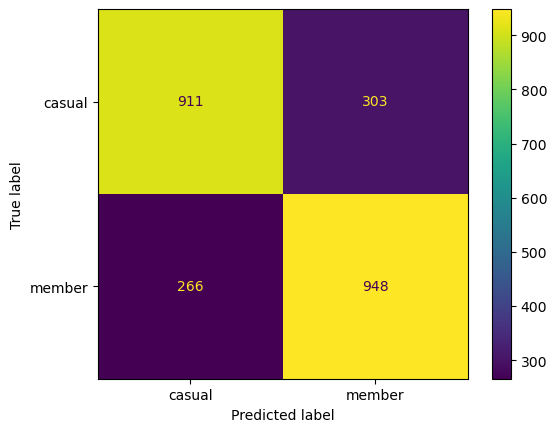

In [137]:
#prediction
y_pred = model_clf.predict(x_test)
df_score7 = GenerateOutput('Decision Tree',x_test,y_test, y_pred,model_clf)
df_score7

## 4.5.8) DecisionTreeClassifier - Cross Validation

In [138]:
df_score8 = CrossVal_model("DecisionTree", x_train, y_train)
df_score8

Avg Balanced Accuracy: 0.7401022678407838
Avg Weighted F1-Score: 0.7400571272349923
Avg AUC-ROC Score: 0.7401022678407838


Model Name  accuracy  f1_score  balanced_accuracy  \
0  DecisionTree - Cross Validation  0.740109  0.740102           0.740057   

   roc_auc score  
0       0.740102

## 4.5.9) Random Forest Classifier 

Random forests are an ensemble learning method for classification tasks. They work by training multiple decision trees on random subsets of the data and then averaging the predictions of all the trees to make a final prediction.



In [139]:
# Create a random forest classifier
mode_clf = RandomForestClassifier(random_state=r_seed)
#Train the classifer on the training data
model_clf.fit(x_train, y_train)

DecisionTreeClassifier()

### 4.5.9.1) Performance

              precision    recall  f1-score   support

      casual       0.77      0.75      0.76      1214
      member       0.76      0.77      0.77      1214

    accuracy                           0.76      2428
   macro avg       0.76      0.76      0.76      2428
weighted avg       0.76      0.76      0.76      2428



Model Name  accuracy  f1_score  balanced_accuracy  roc_auc score
0  RandomForest   0.76318  0.763154            0.76318       0.771417

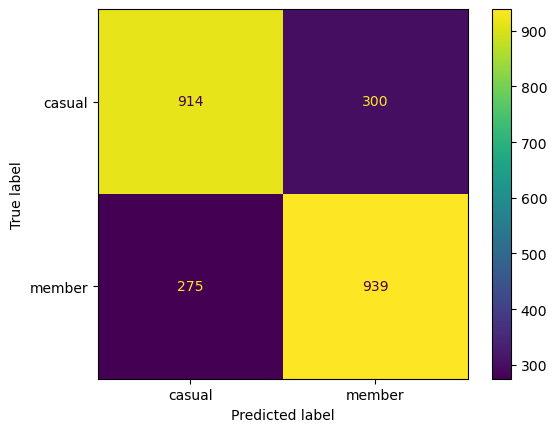

In [140]:
y_pred = model_clf.predict(x_test)
df_score9 = GenerateOutput('RandomForest',x_test,y_test, y_pred, model_clf)
df_score9

## 4.5.10) RandomForestClassifier - Cross Validation

In [141]:
df_score10 = CrossVal_model("RandomForestClassifier", x_train, y_train)
df_score10

Avg Balanced Accuracy: 0.8236169536522894
Avg Weighted F1-Score: 0.8234799199418393
Avg AUC-ROC Score: 0.9023822389787128


Model Name  accuracy  f1_score  \
0  RandomForestClassifier - Cross Validation  0.823622  0.823617   

   balanced_accuracy  roc_auc score  
0            0.82348       0.902382

# Hyperparameter tuning

GridSearchCV and RandomSearchCV are classes in the sklearn.model_selection module that can be used to perform hyperparameter optimization.<br />

GridSearchCV performs an exhaustive search over a specified parameter grid, while RandomSearchCV samples a set of random combinations of the hyperparameters. Both methods use cross-validation to evaluate the performance of the model with different hyperparameter combinations.

## 4.5.11) Logistic Regression - GridSearchCV 

In [147]:
# Define the logistic regression model
logreg = LogisticRegression()

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(x_train, y_train)

#prediction
y_pred = grid_search.predict(x_test)

#Print the best params 
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_params)
print(best_score)

# Use the best hyperparameters to fit the final model
logreg_best = LogisticRegression(**best_params)
logreg_best.fit(X_train, y_train)

# Make predictions on the test set
predictions = logreg_best.predict(X_test)


{'C': 10, 'penalty': 'l2'}
0.5771498476479779


## 4.5.11.1) Performance

              precision    recall  f1-score   support

      casual       0.60      0.60      0.60      1214
      member       0.60      0.60      0.60      1214

    accuracy                           0.60      2428
   macro avg       0.60      0.60      0.60      2428
weighted avg       0.60      0.60      0.60      2428



Model Name  accuracy  f1_score  balanced_accuracy  \
0  LogisticRegression-GridSearchCV  0.602965  0.602965           0.602965   

   roc_auc score  
0       0.614455

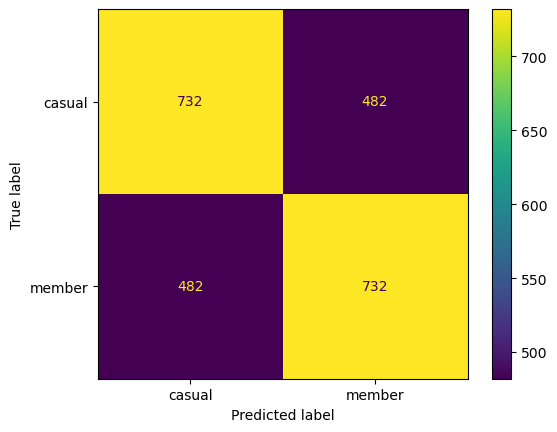

In [149]:
#performance 
df_score11 = GenerateOutput('LogisticRegression-GridSearchCV',x_test,y_test, predictions, logreg_best)
df_score11

## 4.5.12) KNN - RandomSearchCV

The param_dist dictionary specifies the hyperparameters to search over and the possible values for each. The n_iter parameter specifies the number of random combinations to try. The cv parameter specifies the number of folds to use in cross-validatio

In [150]:
# Set up the parameter distribution for the KNN hyperparameters
param_dist = {'n_neighbors': [1, 3, 5, 7, 9],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']}

# Initialize the KNN model
knn = KNeighborsClassifier()

# Initialize the randomized search
random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_dist, cv=5, n_iter=10)

# Fit the randomized search to the data
random_search.fit(x_train, y_train)

# Print the best hyperparameters
print(random_search.best_params_)

# Print the best cross-validation score
print(random_search.best_score_)


{'weights': 'uniform', 'n_neighbors': 1, 'metric': 'manhattan'}
0.7623525210595092


### 4.5.12.1) Performance

In [151]:
# Predict on the test set
y_pred = random_search.predict(x_test)

              precision    recall  f1-score   support

      casual       0.73      0.85      0.78      1214
      member       0.82      0.68      0.75      1214

    accuracy                           0.77      2428
   macro avg       0.77      0.77      0.76      2428
weighted avg       0.77      0.77      0.76      2428



Model Name  accuracy  f1_score  balanced_accuracy  roc_auc score
0  KNN-RandomSearchCV  0.766474  0.764895           0.766474       0.766474

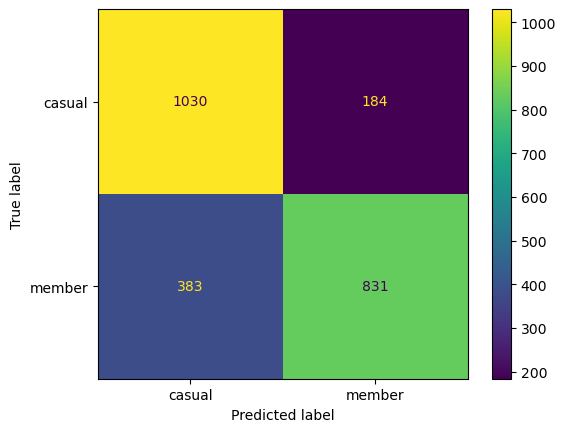

In [152]:
#performance 
df_score12 = GenerateOutput('KNN-RandomSearchCV',x_test,y_test, y_pred, random_search)
df_score12

## 4.5.13) SVM with GridSearchCV

In [163]:
# Set up the parameter grid for the SVM hyperparameters
param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf', 'linear']}

# Initialize the SVM model
svm_svc = svm.SVC(random_state=r_seed, probability=True)

# Initialize the grid search
grid_search = GridSearchCV(estimator=svm_svc, param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

# Print the best cross-validation score
print(grid_search.best_score_)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.6904975689170686


### 4.5.13.1) Performance

In [164]:
# Predict on the test set
y_pred = grid_search.predict(x_test)

              precision    recall  f1-score   support

      casual       0.69      0.72      0.70      1214
      member       0.71      0.67      0.69      1214

    accuracy                           0.70      2428
   macro avg       0.70      0.70      0.70      2428
weighted avg       0.70      0.70      0.70      2428



Model Name  accuracy  f1_score  balanced_accuracy  roc_auc score
0  SVM-GridSearchCV   0.69687  0.696672            0.69687       0.748936

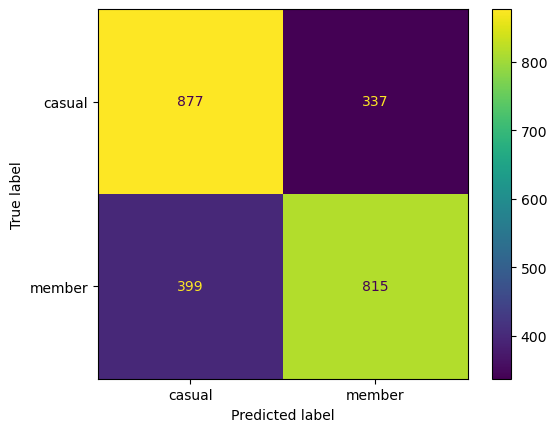

In [165]:
#performance 
df_score13 = GenerateOutput('SVM-GridSearchCV',x_test,y_test, y_pred,grid_search)
df_score13

## 4.5.14) DecisionTrees - RandomizedSearchCV

In [166]:

# Set up the parameter distribution for the decision tree hyperparameters
param_dist = {'max_depth': [1,3,5,7,9],
              'min_samples_split': [2,4,6,8,10,12,14,16],
              'min_samples_leaf': [1,3,5,7,9,13,15,17]}

# Initialize the decision tree model
tree = DecisionTreeClassifier()

# Initialize the randomized search
random_search = RandomizedSearchCV(estimator=tree, param_distributions=param_dist, cv=5, n_iter=10)

# Fit the randomized search to the data
random_search.fit(x_train, y_train)

# Print the best hyperparameters
print(random_search.best_params_)

# Print the best cross-validation score
print(random_search.best_score_)


{'min_samples_split': 12, 'min_samples_leaf': 5, 'max_depth': 9}
0.6701981044102557


### 4.5.14.1) Performance

In [167]:
# Predict on the test set
y_pred = random_search.predict(x_test)

              precision    recall  f1-score   support

      casual       0.65      0.75      0.70      1214
      member       0.71      0.59      0.64      1214

    accuracy                           0.67      2428
   macro avg       0.68      0.67      0.67      2428
weighted avg       0.68      0.67      0.67      2428



Model Name  accuracy  f1_score  balanced_accuracy  \
0  DecisonTree-RandomSearchCV  0.671334  0.669089           0.671334   

   roc_auc score  
0       0.731724

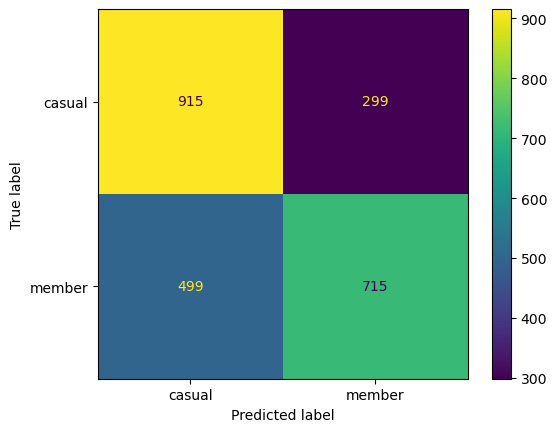

In [168]:
#performance 
df_score14 = GenerateOutput('DecisonTree-RandomSearchCV',x_test,y_test, y_pred,random_search)
df_score14

### 4.5.15) RandomForestClassifier - GridSearchCV

In [170]:
# Set up the parameter grid for the random forest hyperparameters
param_grid = {'n_estimators': [10, 50, 100],
              'max_depth': [None, 5, 10],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Initialize the random forest model
forest = RandomForestClassifier()

# Initialize the grid search
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

# Print the best cross-validation score
print(grid_search.best_score_)


{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
0.8241537991323575


### 4.5.15.1) Performance

In [171]:
# Predict on the test set
y_pred = grid_search.predict(x_test)

              precision    recall  f1-score   support

      casual       0.85      0.79      0.82      1214
      member       0.80      0.86      0.83      1214

    accuracy                           0.83      2428
   macro avg       0.83      0.83      0.83      2428
weighted avg       0.83      0.83      0.83      2428



Model Name  accuracy  f1_score  balanced_accuracy  \
0  RandomForestClassifier-GridSearchCV  0.827018   0.82678           0.827018   

   roc_auc score  
0       0.905237

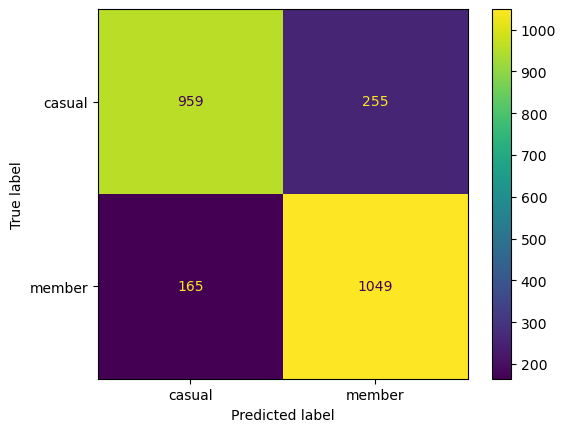

In [172]:
#performance 
df_score15 = GenerateOutput('RandomForestClassifier-GridSearchCV',x_test,y_test, y_pred, grid_search)
df_score15

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

## 5.1 Metric Evaluation 

### 5.1.1 Identification of Evaluation Metric

The following are evaulation metrics used for this particular binary classification. 

**Accuracy**: This is the percentage of correct predictions made by the classifier. It is calculated as (true positives + true negatives) / total samples.

**Precision**: This is the percentage of positive predictions that were correct. It is calculated as true positives / (true positives + false positives).

**F1 score**: This is a weighted average of precision and recall, with a higher score indicating better performance. It is calculated as 2 * (precision * recall) / (precision + recall).

**AUC (Area Under the Curve)**: This is a metric used to evaluate the performance of a binary classifier using an ROC (Receiver Operating Characteristic) curve. The ROC curve plots the true positive rate against the false positive rate at different classification thresholds, and the AUC is the area under this curve. AUC provides a single measure of the classifier's performance.

**Balanced accuracy**: This is a metric used to evaluate the performance of a classifier when the classes are imbalanced. It is defined as the average of the class-specific accuracies, where the class-specific accuracy for a class is the number of true positives for that class divided by the sum of the true positives and false negatives for that class.

In [173]:
modelling_result = pd.concat( [df_score, 
                               df_score2, 
                               df_score3, 
                               df_score4, 
                               df_score5, 
                               df_score6, 
                               df_score7, 
                               df_score8, 
                               df_score9, 
                               df_score10,
                               df_score11, 
                               df_score12, 
                               df_score13, 
                               df_score14, 
                               df_score15, 
                              ] )
modelling_result.sort_values( 'roc_auc score' )

Model Name  accuracy  f1_score  \
0                     SVM - Cross Validation  0.505477  0.505830   
0                                        SVM  0.586491  0.585189   
0     Logistic Regression - Cross Validation  0.576797  0.576801   
0                        Logistic Regression  0.585255  0.585224   
0            LogisticRegression-GridSearchCV  0.602965  0.602965   
0                 DecisonTree-RandomSearchCV  0.671334  0.669089   
0            DecisionTree - Cross Validation  0.740109  0.740102   
0                           SVM-GridSearchCV  0.696870  0.696672   
0                              Decision Tree  0.765651  0.765596   
0                                        KNN  0.759885  0.758293   
0                         KNN-RandomSearchCV  0.766474  0.764895   
0                               RandomForest  0.763180  0.763154   
0                                        KNN  0.712932  0.698168   
0  RandomForestClassifier - Cross Validation  0.823622  0.823617   
0        RandomForestClassifier-GridSearchCV  0.827018  0.826780   

   balanced_accuracy  roc_auc score  
0           0.371319       0.411700  
0           0.586491       0.500000  
0           0.576569       0.599054  
0           0.585255       0.613086  
0           0.602965       0.614455  
0           0.671334       0.731724  
0           0.740057       0.740102  
0           0.696870       0.748936  
0           0.765651       0.757825  
0           0.759885       0.759885  
0           0.766474       0.766474  
0           0.763180       0.771417  
0           0.712932       0.775747  
0           0.823480       0.902382  
0           0.827018       0.905237